In [1]:
import sys
sys.path.append('/home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes')
import numpy as np
from process_file import process_file_modif
from process_file import process_file_modif_varios
import batches_data
import model

import tensorflow as tf 
tf.reset_default_graph()

import entrenamientoevaluacion
from entrenamientoevaluacion import evaluate
from interaccion_no_normalizada import batch_vecinos


In [2]:
#en marco mundo

hotel_pix_path = '../data1/eth/hotel/mundo/mun_pos.csv'
class parameters:
    def __init__(self):
        self.person_max = 28 # 8
        self.obs_len = 8
        self.pred_len = 12
        self.add_social = True
        self.kp_num = 18
        self.add_kp = False
     

In [3]:
# Cargamos los argumentos
arguments = parameters()

# Procesamos los datos de eth_hotel
data_hotel = process_file_modif(hotel_pix_path, arguments, ',')

El numero total de ejemplos
913


# Calculamos el flujo optico

In [ ]:
#vector = batch_vecinos(data_hotel['obs_person'],data_hotel['key_idx'],data_hotel['obs_traj'],arguments)
#np.save('flujo_bien_non_eth_hotel_total_mundo_12.npy',vector )

# Cargamos le flujo

In [4]:
vector_flujo = 'flujo_bien_non_eth_hotel_total_mundo_12.npy'
flujo = np.load(vector_flujo)
flujo.shape

(913, 8, 64)

# Agregamos el flujo al diccionario

In [5]:
data_hotel.update({
    "obs_flujo": flujo,
        })

# Dividimos los datos

In [6]:
#se fija la semilaa
import random
random.seed(0)

# Muestreamos aleatoriamente para separar datos de entrenamiento, validacion y prueba
prob = 0.7 
# La cantidad total de listas de tam 8 
ndata = len(data_hotel[list(data_hotel.keys())[2]])
idx = random.sample(range(ndata), ndata)
long1 = int(ndata*prob)
long2 = int(ndata*0.2)
long3 = int(ndata-long1-long2)

idx_train = idx[0:long1]
idx_test = idx[long1:long1+long2]
idx_val = idx[long1+long2:]

# conjunto de entrenamiento
data1 = {
     "obs_traj": data_hotel["obs_traj"][idx_train],
     "obs_traj_rel": data_hotel["obs_traj_rel"][idx_train],
    
     "pred_traj": data_hotel["pred_traj"][idx_train],
     "pred_traj_rel": data_hotel["pred_traj_rel"][idx_train],
    
     "key_idx": data_hotel["key_idx"][[idx_train]],
    
     
     "obs_flujo" : data_hotel["obs_flujo"][idx_train],
     #"pred_kp": data_pets["pred_kp"][idx_train],
     #"obs_person": data_pets["obs_person"][idx_train],
}

# Conjunto de prueba
data2 = {
     "obs_traj": data_hotel["obs_traj"][idx_test],
     "obs_traj_rel": data_hotel["obs_traj_rel"][idx_test],
     "pred_traj": data_hotel["pred_traj"][idx_test],
     "pred_traj_rel": data_hotel["pred_traj_rel"][idx_test],
     "key_idx": data_hotel["key_idx"][[idx_test]],
     "obs_flujo" : data_hotel["obs_flujo"][idx_test],
     #"pred_kp": data_pets["pred_kp"][idx_test],
     #"obs_person": data_pets["obs_person"][idx_test]
}

# conjunto de validacion
data3 ={
     "obs_traj": data_hotel["obs_traj"][idx_val],
     "obs_traj_rel": data_hotel["obs_traj_rel"][idx_val],
     "pred_traj": data_hotel["pred_traj"][idx_val],
     "pred_traj_rel": data_hotel["pred_traj_rel"][idx_val],
     "key_idx": data_hotel["key_idx"][[idx_val]],
     "obs_flujo" : data_hotel["obs_flujo"][idx_val],
     #"pred_kp": data_pets["pred_kp"][idx_val],
     #"obs_person": data_pets["obs_person"][idx_val],
}


#if arguments.add_kp:
#  print(data3['obs_person_rel'])

print("data_train: "+ str(len(data1[list(data1.keys())[0]])))
print("data_test: "+ str(len(data2[list(data2.keys())[0]])))
print("data_val: "+ str(len(data3[list(data3.keys())[0]])))
#print("data4: "+ str(len(data4[list(data4.keys())[0]])))


data_train: 639
data_test: 182
data_val: 92


/home/andrea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/andrea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/andrea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:52: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will re

# Guardamos los datos

In [7]:
import pickle

#conjunto de entrenamiento
pickle_out = open("data1_non_hotel_12.pickle","wb")
pickle.dump(data1, pickle_out, protocol=2)
pickle_out.close()

#conjunto de prueba
pickle_out = open("data2_non_hotel_12.pickle","wb")
pickle.dump(data2, pickle_out, protocol=2)
pickle_out.close()

#conjunto de validacion
pickle_out = open("data3_non_hotel_12.pickle","wb")
pickle.dump(data3, pickle_out, protocol=2)
pickle_out.close()

# Parametros del modelo

In [9]:
class parameters1:
    def __init__(self, add_kp = None, add_social = None, train_num_examples = None):
        # -----------------
        # Similar a como se procesaron los datos 
        self.obs_len = 8
        self.pred_len = 12
        if add_kp is None:
            print('Parameter add kpp missing')
            return
        if train_num_examples is None:
            print('El parametro train_examples fue olvidado')
            return
        if add_social is None:
            print('Parameter add social missing')
            return
        
        self.add_kp = add_kp
        self.train_num_examples = train_num_examples
        self.add_social = add_social
        
        self.kp_num = 18
        self.kp_size = 18
        #self.maxNumPed = 8
        #self.grid_size = 4
        #self.neighborhood_size = 32
        #self.dimensions = [768,576]
        #self.limites=[-15.88,11.56,-19.09,5.99]
        #self.bound=[0.7,0.5]
        # ------------------
        self.num_epochs = 100
        self.batch_size = 20 # batch size
        self.validate = 300
        self.P = 2 # dimensión
        self.enc_hidden_size = 128 # el nombre lo dice
        self.dec_hidden_size = 128
        self.emb_size = 64
        self.keep_prob = 0.7 # dropout
        
        self.min_ped = 1
        self.seq_len = self.obs_len + self.pred_len
        self.reverse_xy = False
        
        self.activation_func = tf.nn.tanh
        self.activation_func1 = tf.nn.relu
        self.is_train = True
        self.is_test = False
        self.multi_decoder = False
        self.modelname = 'gphuctl'
        
        self.init_lr = 0.002 # 0.01
        self.learning_rate_decay = 0.85
        self.num_epoch_per_decay = 2.0
        self.optimizer = 'adam'
        self.emb_lr = 1.0
        #self.clip_gradient_norm = 10.0
        #Para cuando entreno y quiero guardar el mejor modelo
        self.load_best = True

# Entrenamos el modelo

In [10]:
import os 
from tqdm import tqdm
import tensorflow as tf
import math

tf.reset_default_graph()

arguments = parameters1(add_kp = False, add_social = True,train_num_examples=len(data1['obs_traj']))
model = model.Model(arguments)

train_data = batches_data.Dataset(data1,arguments)
val_data = batches_data.Dataset(data3,arguments)

saver = tf.train.Saver(max_to_keep = 2)
bestsaver = tf.train.Saver(max_to_keep = 2)


trainer = entrenamientoevaluacion.Trainer(model,arguments)
tester = entrenamientoevaluacion.Tester(model, arguments)

#inicializamos las variables globales
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

increment_global_step_op = tf.assign(model.global_step, model.global_step+1)

val_perf = []
loss = -1
metric = 'ade'

best = {metric:999999, 'fde':0, 'step':-1}
is_start = True

num_steps = int(math.ceil(train_data.num_examples/float(arguments.batch_size)))
loss_list = []
print(num_steps)

for i in range(arguments.num_epochs):
    print('Epoca {0}.' .format(i+1), 'lr:', sess.run(trainer.get_lr()))
    
    #For de batches
    for idx, batch in tqdm(train_data.get_batches(arguments.batch_size,num_steps = num_steps),total=num_steps):
        
        sess.run(increment_global_step_op)
        global_step = sess.run(model.global_step)

        #Evaluamos el entrenamiento
        if((global_step%arguments.validate==0) or (arguments.load_best and is_start)):
            tqdm.write("\tsaving model %s..." % global_step)
            checkpoint_path_model = os.path.join('sin_KP_NoN_Hotel_social12', 'model.ckpt')
            saver.save(sess,checkpoint_path_model , global_step = global_step)
            tqdm.write("\tdone")
            
            print('Evaluating')
            results = evaluate(val_data, tester,sess,arguments)
            print(results)
           
            tqdm.write(("\t last loss:%.9f, eval on validation:%s,"
                    " (best %s:%s at step %s) ") % (loss,["%s: %s" % (k, results[k]) for k in sorted(results.keys())], metric,best[metric], best["step"]))
            if results["ade"]< best[metric]:
                best[metric] = results["ade"]
                best["fde"] =results["fde"]
                best["step"] = global_step
                
                tqdm.write("\t saving best model...")
                checkpoint_path_model_best = os.path.join('sin_KP_NoN_Hotel_social-best12', 'model_best.ckpt')
                bestsaver.save(sess,checkpoint_path_model_best,global_step = global_step)
                tqdm.write("\t done.")
                finalperf = results
                val_perf.append((loss, results))
            is_start = False
        loss, train_op = trainer.step(sess, batch)
        loss_list.append(loss)
    
if((global_step % arguments.validate)!=0):
  checkpoint_path_model = os.path.join('sin_KP_NoN_Hotel_social12', 'model.ckpt')
  saver.save(sess,checkpoint_path_model , global_step = global_step)

print("best eval on val %s: %s at %s step y fde es %s " % (metric, best[metric], best["step"],best["fde"]))
       
    

W1227 09:32:22.416335 139946036565760 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:13: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W1227 09:32:22.445230 139946036565760 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:31: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1227 09:32:22.464133 139946036565760 deprecation.py:323] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:70: __init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W1227 09:32:22.466873 139946036565760 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:72: The name tf.nn.rnn_cell.DropoutW

32
('Epoca 1.', 'lr:', 0.002)
	saving model 1...



  0%|          | 0/5 [00:00<?, ?it/s]

	done
Evaluating



100%|##########| 5/5 [00:00<00:00, 12.64it/s]

{'ade': 1.3938532, 'fde': 2.5442421}
	 last loss:-1.000000000, eval on validation:['ade: 1.3938532', 'fde: 2.5442421'], (best ade:999999 at step -1) 
	 saving best model...
	 done.


  6%|▋         | 2/32 [00:00<00:02, 14.25it/s]

('Epoca 2.', 'lr:', 0.002)


  6%|▋         | 2/32 [00:00<00:02, 14.88it/s]

('Epoca 3.', 'lr:', 0.0017000001)


  9%|▉         | 3/32 [00:00<00:01, 22.66it/s]

('Epoca 4.', 'lr:', 0.0017000001)


  9%|▉         | 3/32 [00:00<00:01, 23.19it/s]

('Epoca 5.', 'lr:', 0.0014450002)


  9%|▉         | 3/32 [00:00<00:01, 25.32it/s]

('Epoca 6.', 'lr:', 0.0014450002)


  3%|▎         | 1/32 [00:00<00:03,  9.24it/s]

('Epoca 7.', 'lr:', 0.0012282502)


  9%|▉         | 3/32 [00:00<00:01, 24.93it/s]

('Epoca 8.', 'lr:', 0.0012282502)


  3%|▎         | 1/32 [00:00<00:03,  9.86it/s]

('Epoca 9.', 'lr:', 0.0010440127)


  3%|▎         | 1/32 [00:00<00:03,  9.26it/s]

('Epoca 10.', 'lr:', 0.0010440127)


  0%|          | 0/5 [00:00<?, ?it/s]

	saving model 300...
	done
Evaluating



100%|##########| 5/5 [00:00<00:00, 64.91it/s]

{'ade': 0.34669268, 'fde': 0.6716095}
	 last loss:0.000689940, eval on validation:['ade: 0.34669268', 'fde: 0.6716095'], (best ade:1.3938532 at step 1) 
	 saving best model...
	 done.


  6%|▋         | 2/32 [00:00<00:01, 19.81it/s]

('Epoca 11.', 'lr:', 0.0008874108)


  3%|▎         | 1/32 [00:00<00:03,  9.08it/s]

('Epoca 12.', 'lr:', 0.0008874108)


  9%|▉         | 3/32 [00:00<00:01, 24.77it/s]

('Epoca 13.', 'lr:', 0.0007542992)


  6%|▋         | 2/32 [00:00<00:01, 15.67it/s]

('Epoca 14.', 'lr:', 0.0007542992)


  6%|▋         | 2/32 [00:00<00:02, 13.69it/s]

('Epoca 15.', 'lr:', 0.0006411543)


  6%|▋         | 2/32 [00:00<00:01, 16.24it/s]

('Epoca 16.', 'lr:', 0.0006411543)


  9%|▉         | 3/32 [00:00<00:01, 26.06it/s]

('Epoca 17.', 'lr:', 0.0005449812)


  3%|▎         | 1/32 [00:00<00:03,  9.38it/s]

('Epoca 18.', 'lr:', 0.0005449812)


  3%|▎         | 1/32 [00:00<00:03,  9.46it/s]

('Epoca 19.', 'lr:', 0.00046323403)


 69%|██████▉   | 22/32 [00:00<00:00, 22.54it/s]W1227 09:32:54.069694 139946036565760 deprecation.py:323] From /home/andrea/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.

  0%|          | 0/5 [00:00<?, ?it/s]

	saving model 600...
	done
Evaluating



100%|##########| 5/5 [00:00<00:00, 66.72it/s]

{'ade': 0.3152181, 'fde': 0.5658612}
	 last loss:0.000951603, eval on validation:['ade: 0.3152181', 'fde: 0.5658612'], (best ade:0.34669268 at step 300) 
	 saving best model...
	 done.


  6%|▋         | 2/32 [00:00<00:01, 19.55it/s]

('Epoca 20.', 'lr:', 0.00046323403)


  6%|▋         | 2/32 [00:00<00:02, 13.98it/s]

('Epoca 21.', 'lr:', 0.00039374892)


  3%|▎         | 1/32 [00:00<00:03,  8.85it/s]

('Epoca 22.', 'lr:', 0.00039374892)


  9%|▉         | 3/32 [00:00<00:01, 25.17it/s]

('Epoca 23.', 'lr:', 0.0003346866)


  6%|▋         | 2/32 [00:00<00:02, 14.55it/s]

('Epoca 24.', 'lr:', 0.0003346866)


  9%|▉         | 3/32 [00:00<00:01, 22.22it/s]

('Epoca 25.', 'lr:', 0.00028448363)


  6%|▋         | 2/32 [00:00<00:01, 17.15it/s]

('Epoca 26.', 'lr:', 0.00028448363)


  9%|▉         | 3/32 [00:00<00:01, 23.83it/s]

('Epoca 27.', 'lr:', 0.0002418111)


  3%|▎         | 1/32 [00:00<00:03,  9.71it/s]

('Epoca 28.', 'lr:', 0.0002418111)


  6%|▋         | 2/32 [00:00<00:02, 14.60it/s]

('Epoca 29.', 'lr:', 0.00020553943)
	saving model 900...



100%|##########| 5/5 [00:00<00:00, 75.92it/s]

	done
Evaluating
{'ade': 0.3082466, 'fde': 0.5444428}
	 last loss:0.000504227, eval on validation:['ade: 0.3082466', 'fde: 0.5444428'], (best ade:0.3152181 at step 600) 
	 saving best model...


 22%|██▏       | 7/32 [00:00<00:02, 10.20it/s]

	 done.


  9%|▉         | 3/32 [00:00<00:01, 25.60it/s]

('Epoca 30.', 'lr:', 0.00020553943)


  9%|▉         | 3/32 [00:00<00:01, 25.38it/s]

('Epoca 31.', 'lr:', 0.00017470852)


  3%|▎         | 1/32 [00:00<00:03,  9.47it/s]

('Epoca 32.', 'lr:', 0.00014850224)


  6%|▋         | 2/32 [00:00<00:02, 14.45it/s]

('Epoca 33.', 'lr:', 0.00014850224)


  3%|▎         | 1/32 [00:00<00:03,  9.87it/s]

('Epoca 34.', 'lr:', 0.0001262269)


  3%|▎         | 1/32 [00:00<00:03,  9.67it/s]

('Epoca 35.', 'lr:', 0.0001262269)


  3%|▎         | 1/32 [00:00<00:03,  9.81it/s]

('Epoca 36.', 'lr:', 0.00010729288)


  6%|▋         | 2/32 [00:00<00:02, 14.38it/s]

('Epoca 37.', 'lr:', 0.00010729288)


  6%|▋         | 2/32 [00:00<00:01, 15.01it/s]

('Epoca 38.', 'lr:', 9.119895e-05)


  0%|          | 0/5 [00:00<?, ?it/s]

	saving model 1200...
	done
Evaluating



100%|##########| 5/5 [00:00<00:00, 73.75it/s]

{'ade': 0.30359584, 'fde': 0.54256433}
	 last loss:0.000360218, eval on validation:['ade: 0.30359584', 'fde: 0.54256433'], (best ade:0.3082466 at step 900) 
	 saving best model...
	 done.


  3%|▎         | 1/32 [00:00<00:03,  9.83it/s]

('Epoca 39.', 'lr:', 9.119895e-05)


  3%|▎         | 1/32 [00:00<00:03,  9.56it/s]

('Epoca 40.', 'lr:', 7.751911e-05)


  3%|▎         | 1/32 [00:00<00:03,  9.45it/s]

('Epoca 41.', 'lr:', 7.751911e-05)


  3%|▎         | 1/32 [00:00<00:03,  9.37it/s]

('Epoca 42.', 'lr:', 6.589125e-05)


  3%|▎         | 1/32 [00:00<00:03,  9.37it/s]

('Epoca 43.', 'lr:', 6.589125e-05)


  3%|▎         | 1/32 [00:00<00:03,  9.78it/s]

('Epoca 44.', 'lr:', 5.600756e-05)


  6%|▋         | 2/32 [00:00<00:02, 14.87it/s]

('Epoca 45.', 'lr:', 5.600756e-05)


  3%|▎         | 1/32 [00:00<00:03,  9.75it/s]

('Epoca 46.', 'lr:', 4.7606427e-05)


  3%|▎         | 1/32 [00:00<00:03,  9.05it/s]

('Epoca 47.', 'lr:', 4.7606427e-05)


  0%|          | 0/5 [00:00<?, ?it/s]

	saving model 1500...
	done
Evaluating



 97%|█████████▋| 31/32 [00:01<00:00, 17.28it/s]A

{'ade': 0.30702072, 'fde': 0.55820173}
	 last loss:0.000692169, eval on validation:['ade: 0.30702072', 'fde: 0.55820173'], (best ade:0.30359584 at step 1200) 


  6%|▋         | 2/32 [00:00<00:01, 18.50it/s]

('Epoca 48.', 'lr:', 4.0465464e-05)


  3%|▎         | 1/32 [00:00<00:03,  9.78it/s]

('Epoca 49.', 'lr:', 4.0465464e-05)


  3%|▎         | 1/32 [00:00<00:03,  9.15it/s]

('Epoca 50.', 'lr:', 3.4395645e-05)


  3%|▎         | 1/32 [00:00<00:03,  8.70it/s]

('Epoca 51.', 'lr:', 3.4395645e-05)


  6%|▋         | 2/32 [00:00<00:01, 19.28it/s]

('Epoca 52.', 'lr:', 2.92363e-05)


  6%|▋         | 2/32 [00:00<00:02, 14.37it/s]

('Epoca 53.', 'lr:', 2.92363e-05)


  3%|▎         | 1/32 [00:00<00:03,  9.55it/s]

('Epoca 54.', 'lr:', 2.4850853e-05)


  9%|▉         | 3/32 [00:00<00:01, 25.32it/s]

('Epoca 55.', 'lr:', 2.4850853e-05)


  3%|▎         | 1/32 [00:00<00:03,  8.99it/s]

('Epoca 56.', 'lr:', 2.1123227e-05)


  6%|▋         | 2/32 [00:00<00:01, 15.61it/s]

('Epoca 57.', 'lr:', 2.1123227e-05)


  0%|          | 0/5 [00:00<?, ?it/s]

	saving model 1800...
	done
Evaluating



100%|##########| 5/5 [00:00<00:00, 62.37it/s]

{'ade': 0.295401, 'fde': 0.5265723}
	 last loss:0.001028016, eval on validation:['ade: 0.295401', 'fde: 0.5265723'], (best ade:0.30359584 at step 1200) 
	 saving best model...
	 done.


  3%|▎         | 1/32 [00:00<00:03,  8.04it/s]

('Epoca 58.', 'lr:', 1.7954744e-05)


  6%|▋         | 2/32 [00:00<00:01, 17.54it/s]

('Epoca 59.', 'lr:', 1.7954744e-05)


  9%|▉         | 3/32 [00:00<00:01, 26.13it/s]

('Epoca 60.', 'lr:', 1.5261532e-05)


  3%|▎         | 1/32 [00:00<00:03,  8.54it/s]

('Epoca 61.', 'lr:', 1.5261532e-05)


  6%|▋         | 2/32 [00:00<00:01, 19.19it/s]

('Epoca 62.', 'lr:', 1.2972303e-05)


  9%|▉         | 3/32 [00:00<00:01, 25.74it/s]

('Epoca 63.', 'lr:', 1.1026457e-05)


  3%|▎         | 1/32 [00:00<00:03,  8.96it/s]

('Epoca 64.', 'lr:', 1.1026457e-05)


  6%|▋         | 2/32 [00:00<00:02, 14.55it/s]

('Epoca 65.', 'lr:', 9.37249e-06)


  3%|▎         | 1/32 [00:00<00:03,  8.93it/s]

('Epoca 66.', 'lr:', 9.37249e-06)


  0%|          | 0/5 [00:00<?, ?it/s]

	saving model 2100...
	done
Evaluating



100%|##########| 5/5 [00:00<00:00, 73.19it/s]

{'ade': 0.2938244, 'fde': 0.5201756}
	 last loss:0.000608612, eval on validation:['ade: 0.2938244', 'fde: 0.5201756'], (best ade:0.295401 at step 1800) 
	 saving best model...
	 done.


  9%|▉         | 3/32 [00:00<00:01, 24.07it/s]

('Epoca 67.', 'lr:', 7.966617e-06)


  6%|▋         | 2/32 [00:00<00:01, 17.56it/s]

('Epoca 68.', 'lr:', 7.966617e-06)


  3%|▎         | 1/32 [00:00<00:03,  9.47it/s]

('Epoca 69.', 'lr:', 6.7716246e-06)


  9%|▉         | 3/32 [00:00<00:01, 23.28it/s]

('Epoca 70.', 'lr:', 6.7716246e-06)


  3%|▎         | 1/32 [00:00<00:03,  9.63it/s]

('Epoca 71.', 'lr:', 5.7558805e-06)


  6%|▋         | 2/32 [00:00<00:01, 15.46it/s]

('Epoca 72.', 'lr:', 5.7558805e-06)


  9%|▉         | 3/32 [00:00<00:01, 24.89it/s]

('Epoca 73.', 'lr:', 4.8924985e-06)


  9%|▉         | 3/32 [00:00<00:01, 24.52it/s]

('Epoca 74.', 'lr:', 4.8924985e-06)


  6%|▋         | 2/32 [00:00<00:01, 18.68it/s]

('Epoca 75.', 'lr:', 4.158624e-06)


  0%|          | 0/5 [00:00<?, ?it/s]

	saving model 2400...
	done
Evaluating



100%|##########| 5/5 [00:00<00:00, 67.69it/s]

{'ade': 0.29322854, 'fde': 0.5204826}
	 last loss:0.000973728, eval on validation:['ade: 0.29322854', 'fde: 0.5204826'], (best ade:0.2938244 at step 2100) 
	 saving best model...
	 done.


  9%|▉         | 3/32 [00:00<00:01, 25.45it/s]

('Epoca 76.', 'lr:', 4.158624e-06)


  6%|▋         | 2/32 [00:00<00:01, 16.58it/s]

('Epoca 77.', 'lr:', 3.5348305e-06)


  6%|▋         | 2/32 [00:00<00:02, 14.55it/s]

('Epoca 78.', 'lr:', 3.5348305e-06)


  3%|▎         | 1/32 [00:00<00:03,  8.46it/s]

('Epoca 79.', 'lr:', 3.004606e-06)


  3%|▎         | 1/32 [00:00<00:03,  9.37it/s]

('Epoca 80.', 'lr:', 3.004606e-06)


  6%|▋         | 2/32 [00:00<00:02, 14.82it/s]

('Epoca 81.', 'lr:', 2.5539152e-06)


  3%|▎         | 1/32 [00:00<00:03,  8.66it/s]

('Epoca 82.', 'lr:', 2.5539152e-06)


  6%|▋         | 2/32 [00:00<00:02, 14.62it/s]

('Epoca 83.', 'lr:', 2.170828e-06)


  3%|▎         | 1/32 [00:00<00:03,  9.26it/s]

('Epoca 84.', 'lr:', 2.170828e-06)


  6%|▋         | 2/32 [00:00<00:01, 17.85it/s]

('Epoca 85.', 'lr:', 1.8452038e-06)


  0%|          | 0/5 [00:00<?, ?it/s]

	saving model 2700...
	done
Evaluating



 41%|████      | 13/32 [00:00<00:01, 11.57it/s]A

{'ade': 0.2935217, 'fde': 0.52117246}
	 last loss:0.001001630, eval on validation:['ade: 0.2935217', 'fde: 0.52117246'], (best ade:0.29322854 at step 2400) 


  3%|▎         | 1/32 [00:00<00:04,  6.78it/s]

('Epoca 86.', 'lr:', 1.8452038e-06)


  6%|▋         | 2/32 [00:00<00:01, 18.50it/s]

('Epoca 87.', 'lr:', 1.5684233e-06)


  6%|▋         | 2/32 [00:00<00:02, 13.56it/s]

('Epoca 88.', 'lr:', 1.5684233e-06)


  3%|▎         | 1/32 [00:00<00:03,  9.95it/s]

('Epoca 89.', 'lr:', 1.3331598e-06)


  9%|▉         | 3/32 [00:00<00:01, 24.70it/s]

('Epoca 90.', 'lr:', 1.3331598e-06)


  3%|▎         | 1/32 [00:00<00:03,  9.82it/s]

('Epoca 91.', 'lr:', 1.1331858e-06)


  3%|▎         | 1/32 [00:00<00:03,  8.42it/s]

('Epoca 92.', 'lr:', 1.1331858e-06)


  6%|▋         | 2/32 [00:00<00:01, 15.72it/s]

('Epoca 93.', 'lr:', 9.63208e-07)


  9%|▉         | 3/32 [00:00<00:01, 23.22it/s]

('Epoca 94.', 'lr:', 8.187269e-07)


 72%|███████▏  | 23/32 [00:01<00:00, 14.96it/s]

	saving model 3000...



 80%|########  | 4/5 [00:00<00:00, 30.75it/s]

	done
Evaluating



100%|##########| 5/5 [00:00<00:00, 11.51it/s]

{'ade': 0.2926028, 'fde': 0.51918817}
	 last loss:0.000570383, eval on validation:['ade: 0.2926028', 'fde: 0.51918817'], (best ade:0.29322854 at step 2400) 
	 saving best model...


 78%|███████▊  | 25/32 [00:02<00:01,  4.79it/s]

	 done.


  6%|▋         | 2/32 [00:00<00:02, 14.43it/s]

('Epoca 95.', 'lr:', 8.187269e-07)


  6%|▋         | 2/32 [00:00<00:02, 14.62it/s]

('Epoca 96.', 'lr:', 6.9591783e-07)


  3%|▎         | 1/32 [00:00<00:03,  9.16it/s]

('Epoca 97.', 'lr:', 6.9591783e-07)


  3%|▎         | 1/32 [00:00<00:03,  9.83it/s]

('Epoca 98.', 'lr:', 5.915302e-07)


  6%|▋         | 2/32 [00:00<00:02, 14.20it/s]

('Epoca 99.', 'lr:', 5.915302e-07)


  6%|▋         | 2/32 [00:00<00:02, 12.10it/s]

('Epoca 100.', 'lr:', 5.028007e-07)


100%|██████████| 32/32 [00:02<00:00, 15.07it/s]


best eval on val ade: 0.2926028 at 3000 step y fde es 0.51918817 


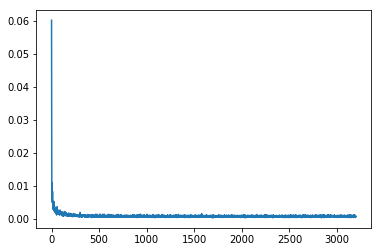

In [11]:
from matplotlib import pyplot as plt
plt.plot(loss_list)
plt.show()

In [12]:
# Guardamos el ultimo modelo
checkpoint_path_model = os.path.join('sin_KP_NoN_Hotel_social12_F', 'model.ckpt')
saver.save(sess,checkpoint_path_model , global_step = global_step)

'sin_KP_NoN_Hotel_social12_F/model.ckpt-3200'

# Restauramos los modelos 

In [13]:
#Ultimo Modelo
path_model = 'sin_KP_NoN_Hotel_social12_F/model.ckpt-3200'
saver.restore(sess=sess, save_path=path_model)


test_data = batches_data.Dataset(data2, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

W1227 09:39:44.522424 139946036565760 deprecation.py:323] From /home/andrea/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
100%|##########| 10/10 [00:00<00:00, 60.65it/s]

Evaluating
{'ade': 0.2804838, 'fde': 0.50400466}


In [14]:
#Modelo12
path_model = 'sin_KP_NoN_Hotel_social12/model.ckpt-3200'
saver.restore(sess=sess, save_path=path_model)


test_data = batches_data.Dataset(data2, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

100%|##########| 10/10 [00:00<00:00, 62.27it/s]

Evaluating
{'ade': 0.2804838, 'fde': 0.50400466}


In [15]:
# Mejor Modelo
path_model = 'sin_KP_NoN_Hotel_social-best12/model_best.ckpt-3000'
saver.restore(sess=sess, save_path=path_model)

test_data = batches_data.Dataset(data2, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

100%|##########| 10/10 [00:00<00:00, 60.77it/s]

Evaluating
{'ade': 0.28054473, 'fde': 0.5046748}
